## Convolutional Neural Networks, and Large Scale Visual Recognition Project (20 pts)
<em>University of Virginia - Introduction to Computer Vision - Spring 2018 - Vicente Ordonez - vicente@virginia.edu</em><br/><br/>

In this project assignment we will apply our knowledge of machine learning and visual recognition using convolutional neural networks to detect various kinds of things from images. We will start from our already familiar CIFAR-10 dataset and we will end up building a more open-ended application.

### 1. Pytorch on the GPU (2pts)
In this section we will experiment with GPU computations and how they speed up some computations under certain conditions.

#### 1.1 Pytorch Installation and GPU Environment Setup (0pts)
We will need to install again pytorch but this time make sure you connect to a GPU enabled machine because a convolutional neural network is very slow on a CPU. Pytorch supports GPU computations for free by using the .cuda() method for tensors and modules. You need to do Runtime -> Change Runtime Type before you run the code below to make sure you are using a machine from Google Cloud that has GPU. Feel free to use your own machine if you have a CUDA-enabled device installed locally.

In [0]:
# Make sure you are using a GPU machine before running this installation!
# You can do this by going to Runtime -> Change runtime type in Google Colab.
#!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install http://www.cs.virginia.edu/~vicente/vision/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install --no-cache-dir -I pillow
!pip3 install tqdm
# Important! You might need to go to Runtime->Restart Runtime after 
# executing this cell so that things are setup properly.
# Also PLEASE delete the output of this cell, do not include it in the 
# assignment. Thanks!

#### 1.2 GPU Environment Testing (2pts)
Now we are going to test the GPU environment in a task of multiplying two square matrices of size $d\times d$. We provide code below sample code and output for this part but you need to complete the test below.

In [1]:
import torch
import time

# Let's create two matrices of size 4x4 and full of ones.
d = 5000
a = torch.rand(d, d)
b = torch.rand(d, d)

# Compute a dot product between the two matrices in CPU.
start_time = time.time()
output = torch.mm(a,b)  # Regular multiplication in CPU.
cpu_time = time.time() - start_time
print('CPU-time {0:.6f}s'.format(cpu_time))

# Compute a dot product between the two matrices in GPU.
start_time = time.time()
a = a.cuda() # Move to GPU.
b = b.cuda() # Move to GPU.
output = torch.mm(a,b)  # Multiplication happens in GPU.
gpu_time = time.time() - start_time
print('GPU-time {0:.6f}s\n'.format(gpu_time))

print('CPU was {0:.2f}x times the GPU time'.format(cpu_time / gpu_time))

CPU-time 4.369723s
GPU-time 4.209306s

CPU was 1.04x times the GPU time


Produce a plot using matplotlib that shows the execution time (y-axis) versus the size $d$ of the square matrices (x-axis) for both GPU and CPU (use values of $d$ = [10, 100, 1000, 5000, 10000]). Answer the following question: For what values of $d$ would you recommend using a GPU?

[0.0049822330474853516, 0.00012612342834472656, 0.02605152130126953, 3.1943600177764893, 25.97525930404663]
[0.0007524490356445312, 0.0002837181091308594, 0.0014994144439697266, 0.02932262420654297, 0.12015175819396973]


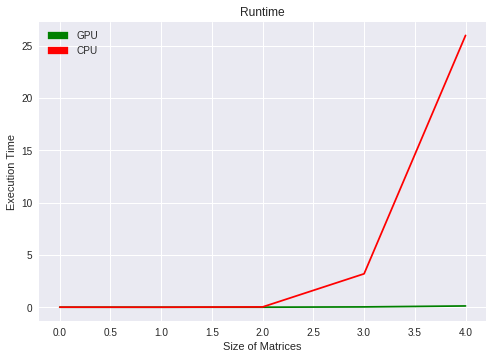

Based on the graph, we should start using GPU when d is 5000 or larger because CPU started to take much longer runtime than CPU


In [2]:

import matplotlib.patches as mpatches
import torch
import time
import matplotlib.pyplot as plt

# Let's create two matrices of size 4x4 and full of ones.
gpu_t=[]
cpu_t=[]
dsize=[10,100,1000,5000,10000]
# dsize=[10,20,100,1000,5000]
for d in dsize:
  a = torch.rand(d, d)
  b = torch.rand(d, d)
    
  # Compute a dot product between the two matrices in CPU.
  start_time = time.time()
  output = torch.mm(a,b)  # Regular multiplication in CPU.
  cpu_t.append(time.time() - start_time)

  # Compute a dot product between the two matrices in GPU.
  start_time = time.time()
  a = a.cuda() # Move to GPU.
  b = b.cuda() # Move to GPU.
  output = torch.mm(a,b)  # Multiplication happens in GPU.
  gpu_t.append(time.time() - start_time)

print(cpu_t)
print(gpu_t)

plt.title("Runtime")
plt.ylabel('Execution Time')
plt.xlabel('Size of Matrices')
green_patch=mpatches.Patch(color='green',label='GPU')
red_patch=mpatches.Patch(color='red',label='CPU')
plt.legend(handles=[green_patch,red_patch])
plt.plot(range(5),gpu_t,'g')
plt.plot(range(5),cpu_t,'r')
plt.show()

print("Based on the graph, we should start using GPU when d is 5000 or larger because CPU started to take much longer runtime than CPU")

**Final Comments:** In the GPU code there is a more or less fixed cost of moving tensors to the GPU, this causes using GPUs slower for small tensors counter-productive. Try timing this separately and estimate the cost of this move. Most functions in pytorch have a CUDA implementation so just by moving tensors to the GPU using .cuda() you can perform any operation in a highly parallel manner on a GPU. Moreover, Pytorch supports parallelization on multiple GPUs as well.<br/><br/>

### 2. Convolutional Neural Networks (CIFAR-10 Dataset) (4pts)
This section will build on the previous project but now we will use a convolutional neural network to obtain higher accuracies.

#### 2.1 CIFAR-10 Data Loading (0pts). 
In this section we will load the CIFAR-10 dataset, a dataset with 50 thousand training images of size 3x32x32 each belonging to one out of 10 possible categories of objects. First, let's download a local copy from the CS server.

In [0]:
import torchvision
from torchvision import datasets

!wget -nc https://www.cs.virginia.edu/~vicente/vision/cifar-10-python.tar.gz -P datalab
!tar xf datalab/cifar-10-python.tar.gz -C datalab
# Please delete the output generated by this cell.

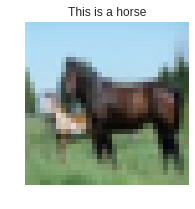

In [4]:
import matplotlib.pyplot as plt
from torchvision import datasets



# This is a convenient data reader.
categories = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
train_data = datasets.CIFAR10('./datalab', train = True)

# This samples the 12-th image from the dataset.
# Try changing the index below to see different images in the dataset.
image, category = train_data[12]

# Display the image and its label.
plt.figure(figsize=(3,3))
plt.title('This is a %s' % categories[category])
plt.imshow(image); plt.grid('off');plt.axis('off')
plt.show()



#### 2.3 Convolutional Neural Network classifier (2pts)
In this section, you will define a convolutional neural network classifier and compute the accuracy of the model on CIFAR-10. Feel free to create any network that you consider would work well. You can get inspiration in some of the convolutional neural network architectures studied in class. I recommend you start with the LeNet architecture included below and start from there.

In [0]:
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
# Convert image to pytorch tensor and normalize input range.
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # This centers the data around zero, and scales the values
    # so that they have unit variance. 
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

# It is possible to pass the transformation function to the data wrappers,
# so that train_data[0] returns a pytorch tensor and a label.
train_data = datasets.CIFAR10(root='./datalab', train = True, transform = preprocess)
validation_data = datasets.CIFAR10(root='./datalab', train = False, transform = preprocess)

x, y = train_data[0]

# Defining the model.
from tqdm import tqdm as tqdm
import torch.nn as nn
import torch.optim as optim

learningRate = 1e-2  # Single learning rate for this lab.

# LeNet is French for The Network, and is taken from Yann Lecun's 1998 paper
# on digit classification http://yann.lecun.com/exdb/lenet/
# This was also a network with just two convolutional layers.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
         # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 25, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(25*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Conv1 + ReLU + MaxPooling.
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        # Conv2 + ReLU + MaPooling.
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        # Linear layer + ReLU.
        out = F.relu(self.fc1(out))
        # Another linear layer + ReLU.
        out = F.relu(self.fc2(out))
        # A final linear layer at the end.
        out = self.fc3(out)
       
        # We will not add nn.LogSoftmax here because nn.CrossEntropy has it.
        # Read the documentation for nn.CrossEntropy.
        
        return out
        
        
# Definition of our network.
classifier = LeNet()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
# This optimizer has access to all the parameters in the model.
#
# It can zero all the parameters by doing:
#                                  optimizer.zero_grad()
#
# It can perform an SGD optimization update step in the direction of
# the gradients for each parameters by doing:
#                                  optimizer.step()
#
optimizer = optim.SGD(classifier.parameters(), lr = learningRate)


#### 2.4 Training the CNN model (2pts)
Train your proposed CNN model and compute the accuracy. Plot the loss for training and validation as training progresses (same as in previous assignment), and the accuracy for training and validation (same as in previous assignment). What is the final accuracy? Hints: Remember to use classifier.train() classifier.eval(), also remember to normalize the input data.

In [6]:
from torch.autograd import Variable

batch_size = 128 

# It additionally has utilities for threaded and multi-parallel data loading.
trainLoader = DataLoader(train_data, batch_size = batch_size, 
                         shuffle = True, num_workers = 0)
valLoader = DataLoader(validation_data, batch_size = batch_size, 
                       shuffle = False, num_workers = 0)



def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, num_epochs = 12):
  # Your code goes here.

#   # Short-cut for the model parameters.
#   weight = classifier.fc3.weight;
#   bias = classifier.fc3.bias;

  training_loss=[]
  training_acc=[]
  validation_loss=[]
  validation_acc=[]

  # Training loop starts.
  for epoch in range(0, num_epochs):
    # This is often needed to prepare model for training.
    classifier.train()
    correct = 0
    cumloss = 0
    # Go over all the training data one batch at a time.
    for (i, (x, y)) in enumerate(trainLoader):
      x = Variable(x)
      y = Variable(y)
      
      #zero the parameter gradients
      optimizer.zero_grad()

      # Compute predictions under the current model.
      yhat = classifier(x)
      
      # Compute the loss with respect to this batch.
      loss = criterion(yhat, y)
      _, max_labels = yhat.data.max(1)
      correct += (max_labels == y.data).sum()
      cumloss += loss.data[0]
      
      loss.backward()
      optimizer.step()
      
      

    print(epoch, 'training-loss: ', cumloss / 50000)
    print(epoch, 'training-accuracy: ', correct / 50000)
    training_loss.append(cumloss/50000)
    training_acc.append(correct/50000)

    classifier.eval()
    correct = 0
    cumloss = 0
    # Compute accuracy on the test set.
    for (i, (x, y)) in enumerate(valLoader):
      x = Variable(x, requires_grad = False)
      y = Variable(y, requires_grad = False)

      # Compute predictions under the current model.
      yhat = classifier(x)
      _, max_labels = yhat.data.max(1)
      correct += (max_labels == y.data).sum()
      cumloss += loss.data[0]


    print(epoch, 'validation-loss: ', cumloss / 10000)
    print(epoch, 'validation-accuracy: ', correct / 10000)
    validation_loss.append(cumloss/10000)
    validation_acc.append(correct/10000)
    print('\n')
   
# Call  your training function and 
train_model(classifier, criterion, optimizer, 
            trainLoader, valLoader, num_epochs = 12)

0 training-loss:  0.017758719177246095
0 training-accuracy:  0.15268
0 validation-loss:  0.017388365030288698
0 validation-accuracy:  0.2224


1 training-loss:  0.015486913187503814
1 training-accuracy:  0.28528
1 validation-loss:  0.014529765856266022
1 validation-accuracy:  0.3244


2 training-loss:  0.014032302441596985
2 training-accuracy:  0.34766
2 validation-loss:  0.014917961311340332
2 validation-accuracy:  0.3616


3 training-loss:  0.013029965975284576
3 training-accuracy:  0.3925
3 validation-loss:  0.011784524595737457
3 validation-accuracy:  0.4013


4 training-loss:  0.01225688163280487
4 training-accuracy:  0.43052
4 validation-loss:  0.01141899902820587
4 validation-accuracy:  0.4303


5 training-loss:  0.0117726628947258
5 training-accuracy:  0.45574
5 validation-loss:  0.013596851766109466
5 validation-accuracy:  0.4624


6 training-loss:  0.011381754457950592
6 training-accuracy:  0.47508
6 validation-loss:  0.01154808704853058
6 validation-accuracy:  0.4693


7 tra

**Final Comments:** You should get a much better classification accuracy of this model. Try running it in some validation images and see how much better are the predictions of this model compared to the one used in a previous assignment.

**My final training accuracy was 0.55118**

### 3. Convolutional Neural Networks (COCO Dataset) (8pts)
In this section we will use a state-of-the-art deep neural network trained on the ILSVRC (Imagenet Large Scale Visual Recognition Challenge) dataset, and "fine-tune" the weights of this network to learn a network that can detect the 80 objects in the COCO Dataset.

#### 3.1 Pre-trained ResNet-50 CNN (0pts)
In this section we will experiment with a ResNet network with 50 layers of depth as seen during class. This network was trained in the ILSVRC task where it was trained on a million images each with one label belonging to 1000 possible classes. First let's load the pre-trained model and categories vocabulary.

In [7]:
import torchvision.models as models

# Download list of 1000 categories for the ILSVRC task in right order.
!wget -nc http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
  
# Load the pre-trained model from the torchvision package.
resnet = models.resnet50(pretrained = True);
resnet.eval();  # Set in evaluation mode! In this case it matters.

--2018-05-04 17:15:20--  http://www.cs.virginia.edu/~vicente/vision/imagenet_class_index.json
Resolving www.cs.virginia.edu (www.cs.virginia.edu)... 128.143.67.11
Connecting to www.cs.virginia.edu (www.cs.virginia.edu)|128.143.67.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K)
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2018-05-04 17:15:20 (1.38 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /content/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 25151356.79it/s]


Now let's run an image through the network. Pay careful attention to all the steps.

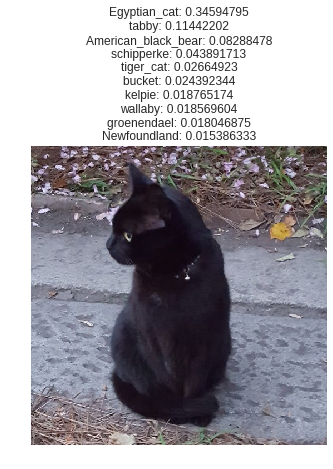

In [8]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import json, io, requests, string
import torch.nn.functional as F
import torch

# 1. Define the appropriate image pre-processing function.
# This has to be the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}


# 3. Read image from URL into a PIL image type.
img_url = 'http://www.cs.virginia.edu/~vicente/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
inputVar =  torch.autograd.Variable(preprocessFn(img_pil).unsqueeze(0))
predictions = resnet(inputVar)

# 5. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid('off'); plt.axis('off');

#### 3.2 Experiment with ResNet (2pts)
Take pictures of two objects for which the ResNet network works really well and show the predictions, do the same for two objects for which the network doesn't do well. Take your own pictures of objects at your place, don't download images from the internet.

This is the picture that I took from Newcomb on Tuesday!


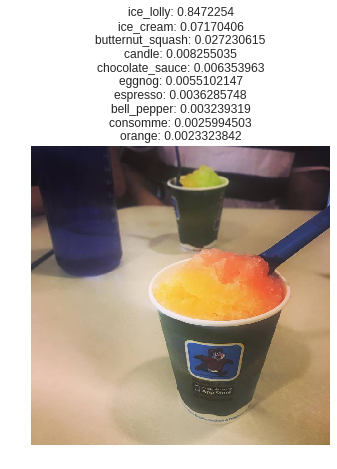

In [9]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import json, io, requests, string
import torch.nn.functional as F
import torch

# 1. Define the appropriate image pre-processing function.
# This has to be the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

# 2. Load the imagenet class names.
imagenetClasses = {int(idx): entry[1] for (idx, entry) in 
                   json.load(open('imagenet_class_index.json')).items()}

print("This is the picture that I took from Newcomb on Tuesday!")

# 3. Read image from URL into a PIL image type.
img1_url = 'https://scontent-iad3-1.xx.fbcdn.net/v/t1.0-9/31870479_1970978329884381_6202444787065290752_n.jpg?_nc_cat=0&_nc_eui2=v1%3AAeGA8C6XKDUBdMME-2fsuZkqiqmRblqOlSmY9Qb0Cxc9ObD3yERVjXp9IqOMDiab636idgoplK0_mzqldWXZGO_qag9GZcDw-XXNJ41uEL2iTg&oh=12d4bb47c2b97712299d3df5a1dda65f&oe=5B53251D'
response1 = requests.get(img1_url)
img1_pil = Image.open(io.BytesIO(response1.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
inputVar1 =  torch.autograd.Variable(preprocessFn(img1_pil).unsqueeze(0))
predictions = resnet(inputVar1)

# 5. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img1_pil); plt.grid('off'); plt.axis('off');


This is the picture that I took in a store in Xiamen, China in the summer of 2017. Hope you enjoy the summer break as well!


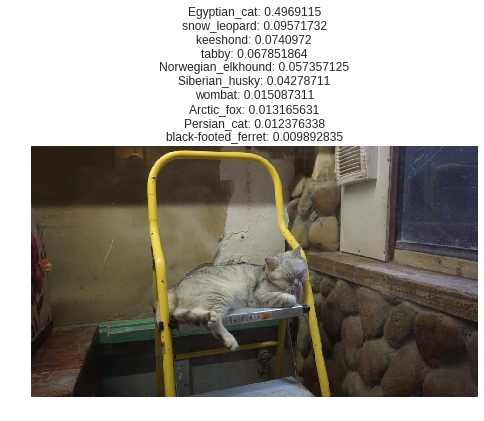

In [11]:
print("This is the picture that I took in a store in Xiamen, China in the summer of 2017. Hope you enjoy the summer break as well!")

#another image
# 3. Read image from URL into a PIL image type.
img_url = 'https://scontent-iad3-1.xx.fbcdn.net/v/t1.0-9/28167080_1930727960576085_6981569116320333794_n.jpg?_nc_cat=0&_nc_eui2=v1%3AAeGNkN6zBORI6MpCktvzCbful4PzZNn8cVLLV6LjbAvOBoTDiGJTH0abPDlTzFhpNbld4I0HXjqLDP4WToNqxSmQVBwlG61jQG90VNQKEvlt-A&oh=76820e5679dd62b16f1fd8d9e574840a&oe=5B8EF8C9'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))

# 4. Forward propagate the image through the CNN.
# Unsqueeze adds a dummy batch dimension needed to pass through the model.
inputVar =  torch.autograd.Variable(preprocessFn(img_pil).unsqueeze(0))
predictions = resnet(inputVar)

# 5. Decode the top 10 classes predicted for this image.
# We need to apply softmax because the model outputs the last linear layer
# outputs and not softmax scores.
probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
probs = (-probs).numpy()[0][:10]; indices = indices.numpy()[0][:10]
preds = [imagenetClasses[idx] + ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

# 6. Show image and predictions
plt.title('\n'.join(preds))
plt.imshow(img_pil); plt.grid('off'); plt.axis('off');

#### 3.3 Fine-tuning ResNet to the COCO-Dataset 80-category dataset (6pts)
The COCO (Common Objects in Context) Dataset has 80 object categories. You can browse it here http://cocodataset.org/#home. This dataset also has bounding box annotations but we will not use them in this project. You will only map each image to an 80-dimensional vector where each entry corresponds to an object type, where the value is 1 if the object-type is present and 0 otherwise. (i.e. will not use box annotations, or not use the number of objects of each type). **Hints:** (1) To build the dataloader for COCO you can reuse the dataloder in pytorch for COCO but you need to modify it to return an 80-dimensional vector as label http://pytorch.org/docs/master/torchvision/datasets.html#coco (2) The 80-category prediction will require a different loss since these labels are not mutually exclusive, you will have to use torch.nn.BCEWithLogitsLoss. **Note:** For speed and in order to reduce network overhead use only 20,000 images for training, and 1,000 images for validation.

In [39]:
!pip3 install Cython
!pip3 install pycocotools
!mkdir coco
import torchvision.transforms as transforms
import torchvision.datasets as dset
import random
from pycocotools.coco import COCO
from torch import zeros, Tensor, from_numpy

!wget -nc http://images.cocodataset.org/zips/train2017.zip -P coco/
!unzip -o -q coco/train2017.zip -d coco/images
!wget -nc  http://images.cocodataset.org/zips/val2017.zip -P coco/
!unzip -o -q coco/val2017.zip -d coco/images
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P coco/
!unzip -o -q coco/annotations_trainval2017.zip -d coco



# 1. Define the appropriate image pre-processing function.
# This has to be the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

dataDir='coco'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco_Train=COCO(annFile)

idx_cat=coco_Train.getCatIds()
cat_idx = {k:v for v,k in enumerate(coco_Train.getCatIds())}

def targetFn(target):
  a = zeros(80).numpy()
  a[[cat_idx[y['category_id']] for y in target ]] = 1
  return from_numpy(a)

dataDir='coco'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
trainSet = dset.CocoDetection('coco/images/train2017',annFile, transform=preprocessFn,
                               target_transform=targetFn)

dataDir='coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
valSet = dset.CocoDetection('coco/images/val2017',annFile, transform=preprocessFn,
                               target_transform=targetFn)


mkdir: cannot create directory ‘coco’: File exists
File ‘coco/train2017.zip’ already there; not retrieving.

File ‘coco/val2017.zip’ already there; not retrieving.

File ‘coco/annotations_trainval2017.zip’ already there; not retrieving.

loading annotations into memory...
Done (t=21.00s)
creating index...
index created!
loading annotations into memory...
Done (t=16.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /content/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 24854452.29it/s]


0 training-loss:  0.0016992231842130423
0 training-accuracy:  0.50905
0 validation-loss:  0.0011113696545362473
0 validation-accuracy:  0.55


1 training-loss:  0.001226099582388997
1 training-accuracy:  0.55955
1 validation-loss:  0.001187160611152649
1 validation-accuracy:  0.556


2 training-loss:  0.0011458210557699204
2 training-accuracy:  0.58065
2 validation-loss:  0.001102808117866516
2 validation-accuracy:  0.594


3 training-loss:  0.001085807292163372
3 training-accuracy:  0.60685
3 validation-loss:  0.0010811348259449005
3 validation-accuracy:  0.624


4 training-loss:  0.0010398248553276062
4 training-accuracy:  0.64
4 validation-loss:  0.0010034556686878205
4 validation-accuracy:  0.649


5 training-loss:  0.00100345495082438
5 training-accuracy:  0.6678
5 validation-loss:  0.0009377276897430419
5 validation-accuracy:  0.677


6 training-loss:  0.0009737251900136471
6 training-accuracy:  0.69025
6 validation-loss:  0.0008842375129461289
6 validation-accuracy:  0.697


7 t

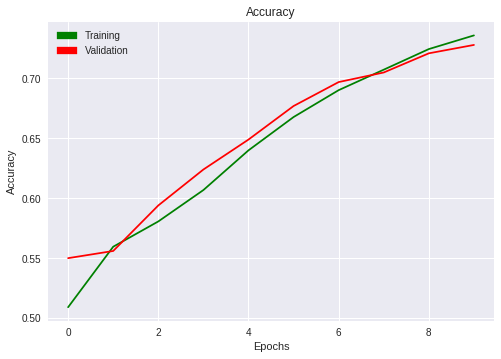

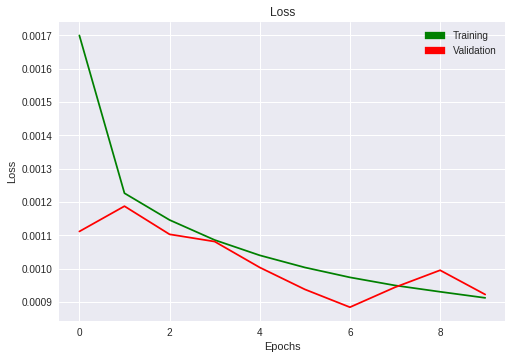

In [13]:
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
import torchvision.models as models
import torch.nn.functional as F
from torch import zeros, Tensor, from_numpy
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches




batch_size = 100
samplerTrain = SubsetRandomSampler(random.sample(range(len(trainSet)), 20000))
samplerVal = SubsetRandomSampler(random.sample(range(len(valSet)), 1000))
trainLoader = DataLoader(trainSet, batch_size=batch_size, shuffle=False,sampler=samplerTrain, num_workers=0)
valLoader = DataLoader(valSet, batch_size=batch_size, shuffle=False,sampler=samplerVal, num_workers=0)


learningRate=1e-2
model = models.resnet18(pretrained = True);
for param in model.parameters():
    param.requires_grad = False
# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(512, 80)
model.cuda()
# Optimize only the classifier
optimizer = optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)
criterion=nn.BCEWithLogitsLoss()

training_loss=[]
training_acc=[]
validation_loss=[]
validation_acc=[]

def train_model(classifier, criterion, optimizer, trainLoader, valLoader, n_epochs=10):
  classifier.cuda()
  classifier.train()
  
  for epoch in range(n_epochs):
    classifier.train()
    cumloss=0
    correct=0
    for (i, (x, y)) in enumerate(trainLoader):
      x = Variable(x.cuda())
      y = Variable(y.cuda())
      
      #zero the parameter gradients
      optimizer.zero_grad()

      # Compute predictions under the current model.
      yhat = classifier(x)
      
      # Compute the loss with respect to this batch.
      loss = criterion(yhat, y)
      
      _, max_labels = (F.softmax(yhat,dim=1).data).max(1)
      correct += (y.data.gather(1,max_labels.view(-1,1))).sum()
      
      loss.backward()
      optimizer.step()
      cumloss+= loss.data[0]
      

    print(epoch, 'training-loss: ', cumloss / 20000)
    print(epoch, 'training-accuracy: ', correct / 20000)
    training_loss.append(cumloss/20000)
    training_acc.append(correct/20000)

    classifier.eval()
    correct = 0
    cumloss = 0
    # Compute accuracy on the test set.
    for (i, (x, y)) in enumerate(valLoader):
      x = Variable(x.cuda(), requires_grad = False)
      y = Variable(y.cuda(), requires_grad = False)

      # Compute predictions under the current model.
      yhat = classifier(x)
      _, max_labels = (F.softmax(yhat,dim=1).data).max(1)
      correct += (y.data.gather(1,max_labels.view(-1,1))).sum()
      cumloss += loss.data[0]


    print(epoch, 'validation-loss: ', cumloss / 1000)
    print(epoch, 'validation-accuracy: ', correct / 1000)
    validation_loss.append(cumloss/1000)
    validation_acc.append(correct/1000)
    print('\n')
    

# Call  your training function and 
train_model(model, criterion, optimizer, 
            trainLoader, valLoader, n_epochs = 10)



#first figure
plt.title("Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
green_patch=mpatches.Patch(color='green',label='Training')
red_patch=mpatches.Patch(color='red',label='Validation')
plt.legend(handles=[green_patch,red_patch])
plt.plot(range(10),training_acc,'g')
plt.plot(range(10),validation_acc,'r')
plt.show()

#second figure
plt.title("Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
green_patch=mpatches.Patch(color='green',label='Training')
red_patch=mpatches.Patch(color='red',label='Validation')
plt.legend(handles=[green_patch,red_patch])
plt.plot(range(10),training_loss,'g')
plt.plot(range(10),validation_loss,'r')
plt.show()

Show three example results of your trained model on the validation set of the COCO dataset. More especifically show the top ten predicted categories along with the score for each for three sample images.

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
loading annotations into memory...
Done (t=4.06s)
creating index...
index created!


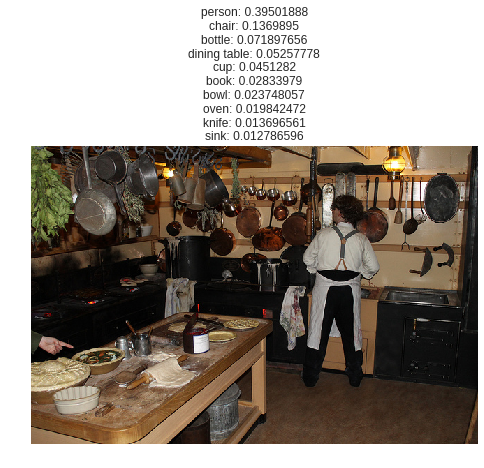

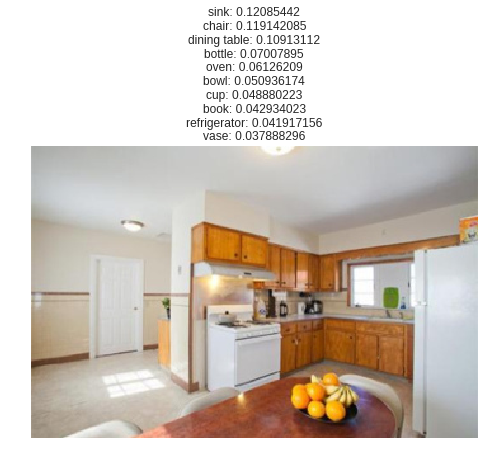

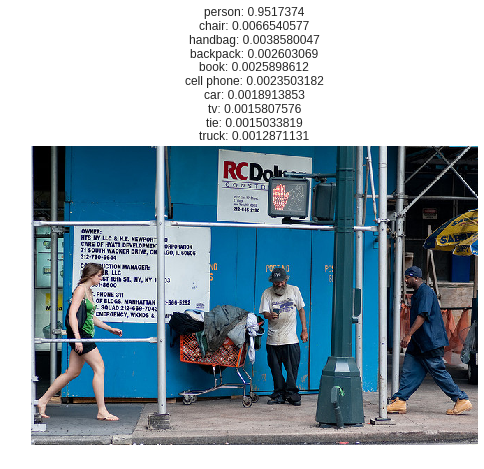

In [44]:
# Your code goes here.
import torch
import torch.nn.functional as F
import requests, io
!pip3 install Cython
!pip3 install pycocotools
from pycocotools.coco import COCO



classifier.eval()
dataDir='coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco_val=COCO(annFile)

# This has to be the preprocessing function used during training. 
preprocessFn = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])

dataDir='coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
vals = dset.CocoDetection('coco/images/val2017',annFile, transform=preprocessFn)
for i in range(3):
  x,y=vals[i]
  
  inputVar = torch.autograd.Variable(x.unsqueeze(0).cuda())
  predictions = model(inputVar)
  
  # 5. Decode the top 10 classes predicted for this image.
  # We need to apply softmax because the model outputs the last linear layer
  # outputs and not softmax scores.
  probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
  probs = (-probs).cpu().numpy()[0][:10]; indices = indices.cpu().numpy()[0][:10]
  preds = [coco_Train.loadCats([idx_cat[idx]])[0]['name'] +
           ': ' + str(prob) for (prob, idx) in zip(probs, indices)]

  # 6. Show image and predictions
  img_url = coco_val.loadImgs([y[0]['image_id']])[0]['coco_url']
  response = requests.get(img_url)
  img_pil = Image.open(io.BytesIO(response.content))
  plt.figure(i+1)
  plt.title('\n'.join(preds))
  plt.imshow(img_pil); plt.grid('off'); plt.axis('off');

**Final Comments:** In this section you learned to use a very deep neural network that was trained to recognize 1000 categories, then you finetuned this network to another dataset that only had 80 categories, and for a different criterion (loss function). How would you measure the accuracy of this model?

### 4. Visual Recognition Open (6pts)
In this section implement any visual recognition application of your choice using data of your own choice. For instance you could train a Convolutional Neural Network on the Dogs vs Cats Kaggle competition dataset https://www.kaggle.com/c/dogs-vs-cats. The training data has 25,000 images, I already separated the images into training: 20,000 images and validation: 5,000 images. You can download the training, validation splits from the following dropbox link: [cats_dogs.zip](https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip). You will have to write your own dataset class inheriting from torch.utils.data.Dataset, and a model that trains on this dataset. As usual, include plots.

--2018-05-04 20:08:38--  https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/oFzHfidMNfQd97NmUUHin5n0wOVYCJ9BAyxdYdAaKDKf8SYCV9fgLeEKiNNF55CF/file [following]
--2018-05-04 20:08:39--  https://dl.dropboxusercontent.com/content_link/oFzHfidMNfQd97NmUUHin5n0wOVYCJ9BAyxdYdAaKDKf8SYCV9fgLeEKiNNF55CF/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.9.6, 2620:100:601f:6::a27d:906
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.9.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 572253727 (546M) [application/zip]
Saving to: ‘cats_dogs/cats_dogs.zip’

cats_dogs.zip       100%[===================>] 545.74M  30.7MB/s    in 17s     

2018-05-0

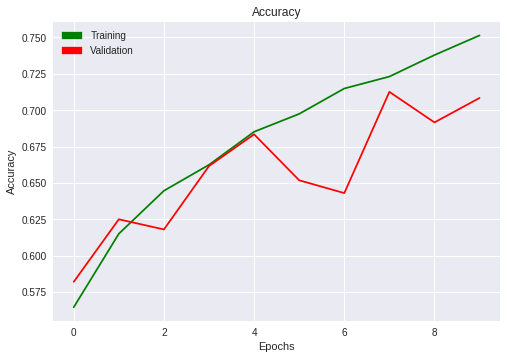

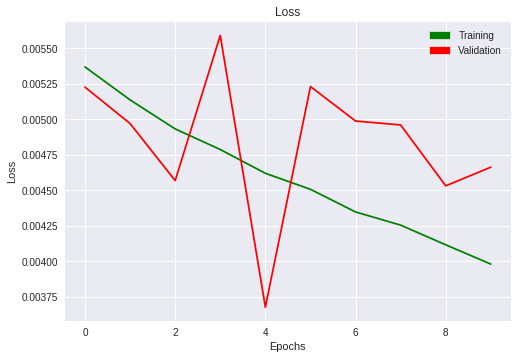

In [45]:
# Download and unzip the cats vs dgos dataset.
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.patches as mpatches
from torchvision import models, transforms
from PIL import Image
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm as tqdm
from torch.autograd import Variable



!wget -nc https://www.dropbox.com/s/sg7q9hhdzdxoeh2/cats_dogs.zip -P cats_dogs
!unzip -o -q cats_dogs/cats_dogs.zip -d cats_dogs/images/
#delete DS_Store
!find . -type f ! -name '*.jpg' -delete 



cats_dogs = ['cats', 'dogs']
class CatsDogsDataset(Dataset):
  
  def __init__ (self, root_dir, train=True, transform=None):
    self.set_path="trainset"
    if not train:
      self.set_path="valset"
      
    print(self.set_path)
    self.root_dir= os.path.join(root_dir, self.set_path)
    self.transform=transform
  def __len__(self):
    return len(os.listdir(self.root_dir))
  
  def __getitem__(self, idx):
    file_name = os.listdir(self.root_dir)[idx]
    
    img_name = os.path.join(self.root_dir, file_name)
    image=Image.open(img_name)
    if self.transform:
      image=self.transform(image)
    target = 1
    if "cat" in file_name:
      target=0
    return image, target

# This has to be the preprocessing function used during training. 
preprocess = transforms.Compose(
    [transforms.Resize(256), 
     transforms.CenterCrop(224), 
     transforms.ToTensor(), 
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])])
train_data=CatsDogsDataset("cats_dogs/images/", train=True, transform = preprocess)
validation_data=CatsDogsDataset("cats_dogs/images/", train=False, transform = preprocess)

learningRate=1e-2

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
         # Convolutional layers.
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Linear layers.
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        # Conv1 + ReLU + MaxPooling.
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        
        # Conv2 + ReLU + MaPooling.
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        
        # This flattens the output of the previous layer into a vector.
        out = out.view(out.size(0), -1) 
        # Linear layer + ReLU.
        out = F.relu(self.fc1(out))
        # Another linear layer + ReLU.
        out = F.relu(self.fc2(out))
        # A final linear layer at the end.
        out = self.fc3(out)
       
        # We will not add nn.LogSoftmax here because nn.CrossEntropy has it.
        # Read the documentation for nn.CrossEntropy.
        
        return out
        
        
# Definition of our network.
classifier = LeNet()

#Definition of our loss.
criterion = nn.CrossEntropyLoss()

# Definition of optimization strategy.
# This optimizer has access to all the parameters in the model.
#
# It can zero all the parameters by doing:
#                                  optimizer.zero_grad()
#
# It can perform an SGD optimization update step in the direction of
# the gradients for each parameters by doing:
#                                  optimizer.step()
#
optimizer = optim.SGD(classifier.parameters(), lr = learningRate)

batch_size = 128 

# It additionally has utilities for threaded and multi-parallel data loading.
trainLoader = DataLoader(train_data, batch_size = batch_size, 
                         shuffle = True, num_workers = 0)
valLoader = DataLoader(validation_data, batch_size = batch_size, 
                       shuffle = False, num_workers = 0)

training_loss=[]
training_acc=[]
validation_loss=[]
validation_acc=[]

def train_model(classifier, criterion, optimizer, 
                trainLoader, valLoader, num_epochs = 10):

  classifier.cuda()
  classifier.train()
  
  # Training loop starts.
  for epoch in range(0, num_epochs):
    # This is often needed to prepare model for training.
    classifier.train()
    correct = 0
    cumloss = 0
    # Go over all the training data one batch at a time.
    for (i, (x, y)) in enumerate(trainLoader):
      x = Variable(x.cuda())
      y = Variable(y.cuda())
      
      #zero the parameter gradients
      optimizer.zero_grad()

      # Compute predictions under the current model.
      yhat = classifier(x)
      
      # Compute the loss with respect to this batch.
      loss = criterion(yhat, y)
      _, max_labels = yhat.data.max(1)
      correct += (max_labels == y.data).sum()
      
      loss.backward()
      optimizer.step()
      
      # if i % 50 == 0: print(epoch, i, loss.data[0])
      cumloss += loss.data[0]

    print(epoch, 'training-loss: ', cumloss / 20000)
    print(epoch, 'training-accuracy: ', correct / 20000)
    training_loss.append(cumloss/20000)
    training_acc.append(correct/20000)

    
    
    classifier.eval()
    correct = 0
    cumloss = 0
    # Compute accuracy on the test set.
    for (i, (x, y)) in enumerate(valLoader):
      x = Variable(x.cuda(), requires_grad = False)
      y = Variable(y.cuda(), requires_grad = False)

      # Compute predictions under the current model.
      yhat = classifier(x)
      _, max_labels = yhat.data.max(1)
      correct += (max_labels == y.data).sum()
      cumloss += loss.data[0]


    print(epoch, 'validation-loss: ', cumloss / 5000)
    print(epoch, 'validation-accuracy: ', correct / 5000)
    validation_loss.append(cumloss/5000)
    validation_acc.append(correct/5000)
    print('\n')
   
# Call  your training function and 
train_model(classifier, criterion, optimizer, 
            trainLoader, valLoader, num_epochs = 10)  
#first figure
plt.title("Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
green_patch=mpatches.Patch(color='green',label='Training')
red_patch=mpatches.Patch(color='red',label='Validation')
plt.legend(handles=[green_patch,red_patch])
plt.plot(range(10),training_acc,'g')
plt.plot(range(10),validation_acc,'r')
plt.show()

#second figure
plt.title("Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
green_patch=mpatches.Patch(color='green',label='Training')
red_patch=mpatches.Patch(color='red',label='Validation')
plt.legend(handles=[green_patch,red_patch])
plt.plot(range(10),training_loss,'g')
plt.plot(range(10),validation_loss,'r')
plt.show()
      

**Final Comments:** If you didn't work in the dogs vs cats dataset, does your task affect people directly? Could your task cause any harm or unfairness to end users of your application? These are questions you should be asking yourself. Finally, I hope you enjoyed the Introduction to Computer Vision class this semester!